
# **Présentation générale du jeu de données**

In [1]:
import os
import math

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

arbres = pd.read_csv("p2-arbres-fr.csv", sep=";") # raw dataset

arbres = arbres.drop(['complement_addresse', 'numero', 'lieu', 'id_emplacement', 'genre', 'espece', 'variete', 'remarquable'], axis=1)

arrdts = ["PARIS 1ER ARRDT"] + [f"PARIS {i+2}E ARRDT"for i in range(19)] + ['BOIS DE BOULOGNE', 'BOIS DE VINCENNES', 'HAUTS-DE-SEINE', 'SEINE-SAINT-DENIS', 'VAL-DE-MARNE']

especes = arbres.libelle_francais.unique() # list of unique tree species

stages = [x for x in arbres.stade_developpement.unique() if str(x) != 'nan'] # list of unique grow stages

dom = [x for x in arbres.domanialite.unique() if str(x) != 'nan'] # list of types of locations

color_dict = dict({'J':'limegreen', 'JA':'lime', 'A':'green', 'M':'darkgreen', 'Jardin':'green', 'Alignement':'brown', 'DJS':'red', 'DFPE':'dodgerblue', 'CIMETIERE':'black', 'DASCO':'blue', 'DAC':'orange', 'PERIPHERIQUE':'yellow', 'DASES':'purple'})

print(f"Le dataset est composé de {arbres.shape[1]} colonnes et {arbres.shape[0]} arbres.")



Le dataset est composé de 10 colonnes et 200137 arbres.


In [2]:
arbres.head()

,id,type_emplacement,domanialite,arrondissement,libelle_francais,circonference_cm,hauteur_m,stade_developpement,geo_point_2d_a,geo_point_2d_b
0,99874,Arbre,Jardin,PARIS 7E ARRDT,Marronnier,20,5,NaN,48.857620,2.320962
1,99875,Arbre,Jardin,PARIS 7E ARRDT,If,65,8,A,48.857656,2.321031
2,99876,Arbre,Jardin,PARIS 7E ARRDT,If,90,10,A,48.857705,2.321061
3,99877,Arbre,Jardin,PARIS 7E ARRDT,Erable,60,8,A,48.857722,2.321006
4,99878,Arbre,Jardin,PARIS 17E ARRDT,Arbre à miel,38,0,NaN,48.890435,2.315289


Affichage des statistiques du dataset

In [3]:
def show_global_stats():
    print("\nValeurs manquantes pour chaque colonne:\n")
    print(arbres.isnull().sum())
    print("\n\nStatistiques de l'attribut circonference:\n")
    print(arbres["circonference_cm"].describe())
    print("\n\nStatistiques de l'attribut hauteur:\n")
    print(arbres["hauteur_m"].describe())
    
show_global_stats()


Valeurs manquantes pour chaque colonne:

id                         0
type_emplacement           0
domanialite                1
arrondissement             0
libelle_francais        1497
circonference_cm           0
hauteur_m                  0
stade_developpement    67205
geo_point_2d_a             0
geo_point_2d_b             0
dtype: int64


Statistiques de l'attribut circonference:

count    200137.000000
mean         83.380479
std         673.190213
min           0.000000
25%          30.000000
50%          70.000000
75%         115.000000
max      250255.000000
Name: circonference_cm, dtype: float64


Statistiques de l'attribut hauteur:

count    200137.000000
mean         13.110509
std        1971.217387
min           0.000000
25%           5.000000
50%           8.000000
75%          12.000000
max      881818.000000
Name: hauteur_m, dtype: float64


# **Démarche méthodologique d’analyse de données**

### Valeurs manquantes et aberrantes

Ajout d'une catégorie "espèce inconnue" pour éviter les erreurs de traitement sur les données non renseignées

In [4]:
null_species_trees = arbres[arbres["libelle_francais"].isnull()]
for index, row in null_species_trees.iterrows():
    arbres.at[index, "libelle_francais"] = "Inconnu"

Traitement des colonnes numériques (hauteur et circonférence). Les valeurs manquantes ou nulles sont remplacées par la médiane des arbres de la même espèce dans le même arrondissement. Les valeurs aberrantes (supérieures à la somme du 3e quartile et de 3x la distance interquartille) sont remplacées par une valeur par défaut (somme du 3e quartille et 1.5x la distance interquartille).

In [5]:
caracs = ["circonference_cm", "hauteur_m"]

corrections = pd.DataFrame(columns=["Espece", "Nombre d'arbres", "Valeurs aberrantes/manquantes"])

for nesp, esp in enumerate(especes):
    
    counter = 0
     
    # getting subdafaframe for a specific specie
    espece_arbres = arbres[arbres["libelle_francais"] == esp]
    # getting desciptive statistics
    stats = espece_arbres[caracs].describe()

    for carac in caracs:
        # calculating thresholds for aberrant values
        q1 = stats[carac].loc["25%"]
        q2 = stats[carac].loc["50%"]
        q3 = stats[carac].loc["75%"]
        lower_bound = 0 # a newborn tree can be any height or circumference
        upper_bound = q3 + 3 * (q3 - q1)
        default_value = q3 + 1.5 * (q3 - q1)
        
        # replacing aberrant & missing values in parent dataframe
        for index, row in espece_arbres.iterrows():
            if math.isnan(row[carac]) or row[carac] == 0: # missing value, replacing with median
                counter += 1
                arbres.at[index, carac] = q2
            if row[carac] > upper_bound: # too tall
                counter += 1
                arbres.at[index, carac] = default_value
            elif row[carac] < lower_bound: # too small, replacing with median
                counter += 1
                arbres.at[index, carac] = q2
                
    corrections.loc[nesp] = [esp, espece_arbres.shape[0], counter]

corrections



,Espece,Nombre d'arbres,Valeurs aberrantes/manquantes
0,Marronnier,25207,4121
1,If,1995,797
2,Erable,18389,10088
3,Arbre à miel,53,40
4,Platane,42508,5839
...,...,...,...
188,Ormeau épineux,1,2
189,Ostryer,1,2
190,Xanthoceras,1,2
191,Parrotiopsis,2,4


Ajout des stades de développement manquants. Pour l'attribuer à un arbre, on calcule la moyenne des hauteurs des arbres de la même espèce, dans le même arrondissement, pour chaque stade de développement. Enfin, on assigne le stade dont la moyenne associée est la plus proche de la hauteur de l'arbre.

In [6]:
default_avgs = [0, 0, 0, 0]
default_avgs[stages.index("J")] = 1
for arrdt in arrdts:
    # get all trees for each arrdt
    arrdt_arbres = arbres[arbres["arrondissement"] == arrdt]
    # get trees without specified development stage
    null_stage_trees = arrdt_arbres[arrdt_arbres["stade_developpement"].isnull()]
    print(f"In {arrdt}, {null_stage_trees.shape[0]} development stages were missing.")
    # get species concerned
    for spe in null_stage_trees.libelle_francais.unique():
        avgs = []
        # get trees with same specie in specific arrdt
        current_trees = arrdt_arbres[arrdt_arbres["libelle_francais"] == spe]
        current_null_trees = null_stage_trees[null_stage_trees["libelle_francais"] == spe]
        # get average height for trees with same location and specie, for each stage
        for stage in stages:
            avgs.append(current_trees[current_trees["stade_developpement"] == stage]["hauteur_m"].mean())
        # in case no other similar tree is documented, we assign the "Junior" stage
        if all([math.isnan(x) for x in avgs]): avgs = [x for x in default_avgs]
        # replace missing development stages with closest distance to previously calculated averages
        for index, row in current_null_trees.iterrows():
            h = row["hauteur_m"]
            new_stage = stages[avgs.index(min(avgs, key=lambda x:abs(x-h)))]
            arbres.at[index, "stade_developpement"] = new_stage

In PARIS 1ER ARRDT, 411 development stages were missing.
In PARIS 2E ARRDT, 79 development stages were missing.
In PARIS 3E ARRDT, 259 development stages were missing.
In PARIS 4E ARRDT, 724 development stages were missing.
In PARIS 5E ARRDT, 636 development stages were missing.
In PARIS 6E ARRDT, 339 development stages were missing.
In PARIS 7E ARRDT, 731 development stages were missing.
In PARIS 8E ARRDT, 926 development stages were missing.
In PARIS 9E ARRDT, 168 development stages were missing.
In PARIS 10E ARRDT, 613 development stages were missing.
In PARIS 11E ARRDT, 1181 development stages were missing.
In PARIS 12E ARRDT, 3821 development stages were missing.
In PARIS 13E ARRDT, 6451 development stages were missing.
In PARIS 14E ARRDT, 1244 development stages were missing.
In PARIS 15E ARRDT, 7427 development stages were missing.
In PARIS 16E ARRDT, 4867 development stages were missing.
In PARIS 17E ARRDT, 3302 development stages were missing.
In PARIS 18E ARRDT, 2969 developm

Vérification des corrections

In [7]:
show_global_stats()


Valeurs manquantes pour chaque colonne:

id                     0
type_emplacement       0
domanialite            1
arrondissement         0
libelle_francais       0
circonference_cm       0
hauteur_m              0
stade_developpement    0
geo_point_2d_a         0
geo_point_2d_b         0
dtype: int64


Statistiques de l'attribut circonference:

count    200137.000000
mean         87.416705
std          55.905937
min           0.000000
25%          45.000000
50%          77.000000
75%         115.000000
max        2150.000000
Name: circonference_cm, dtype: float64


Statistiques de l'attribut hauteur:

count    200137.000000
mean          9.654487
std           5.062452
min           0.000000
25%           5.000000
50%          10.000000
75%          12.000000
max          58.000000
Name: hauteur_m, dtype: float64


### Fonction d'analyse
Cette fonction a pour but de montrer les insights d'un arrondissment spécifique.

In [8]:
def arrdt_insights(location_index, show_stats=False):
    
    tmp_df = arbres[arbres["arrondissement"] == arrdts[location_index]]
    
    if show_stats:
        # display statistic indicators for height and width
        print("Statistiques descriptives de la hauteur\n")
        print(tmp_df["hauteur_m"].describe().drop(['count', 'std', 'min', 'max']))
        print("\n\nStatistiques descriptives de la circonférence\n")
        print(tmp_df["circonference_cm"].describe().drop(['count', 'std', 'min', 'max']))
    
    # display  height and width distributions
    fig2, axs = plt.subplots(ncols=2, figsize=(16,5))
    sns.histplot(tmp_df, x="hauteur_m", bins=10, ax=axs[0]).set_title(f"Distribution des hauteurs ({arrdts[location_index]})")
    sns.histplot(tmp_df, x="circonference_cm", bins=30, ax=axs[1]).set_title(f"Distribution des circonférences ({arrdts[location_index]})")
    
    # plot maps for development stages and specific locations
    fig, axs2 = plt.subplots(ncols=2, figsize=(16,8))
    mymap = sns.scatterplot(ax=axs2[0], data=tmp_df, x="geo_point_2d_b", y="geo_point_2d_a", hue="stade_developpement", palette=color_dict)
    mymap.set_title(f"Stade de développement des arbres ({arrdts[location_index]})")
    mymap2 = sns.scatterplot(ax=axs2[1], data=tmp_df, x="geo_point_2d_b", y="geo_point_2d_a", hue="domanialite", palette=color_dict)
    mymap2.set_title(f"Domanialité des arbres ({arrdts[location_index]})")
    
    

# **Synthèse de l'analyse de données**

### Analyse globale

Text(0.5, 1.0, 'Répartition des 10 espèces les plus représentées')

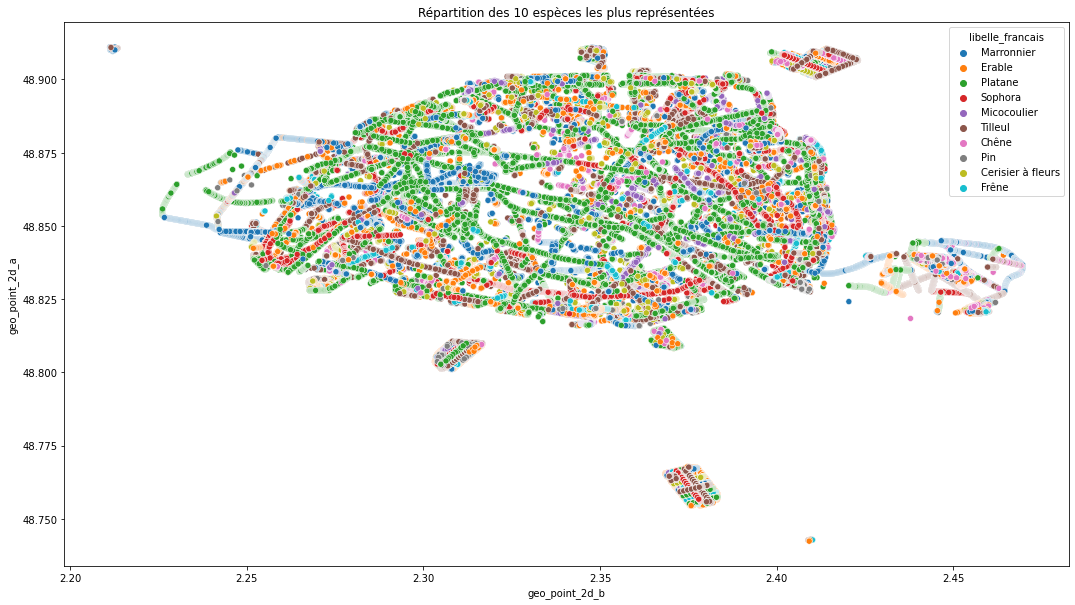

In [9]:
top10 = arbres[arbres.libelle_francais.isin(arbres.libelle_francais.value_counts().nlargest(10).index)]
plt.figure(figsize=(18,10))
mymap = sns.scatterplot(data=top10, x="geo_point_2d_b", y="geo_point_2d_a", hue="libelle_francais")
mymap.set_title("Répartition des 10 espèces les plus représentées")

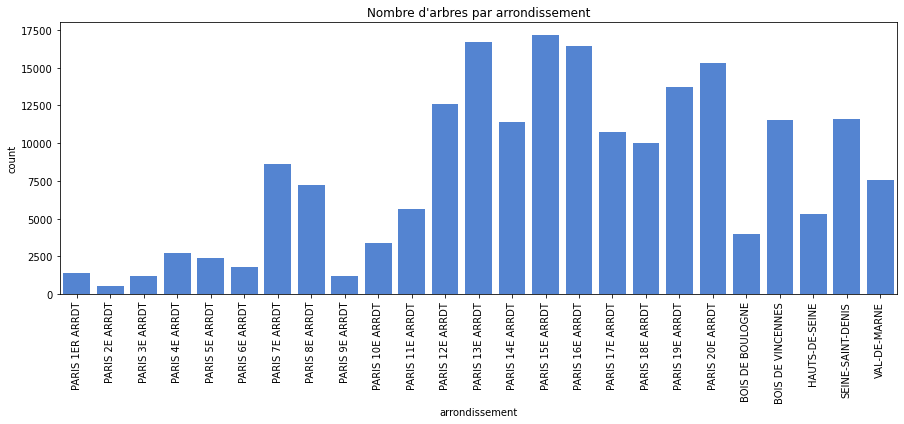

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))
grp = sns.countplot(ax=ax, x="arrondissement", data=arbres, color=(0.25, 0.5, 0.9), order=arrdts)
grp.set_title("Nombre d'arbres par arrondissement")
for item in grp.get_xticklabels():
    item.set_rotation(90)

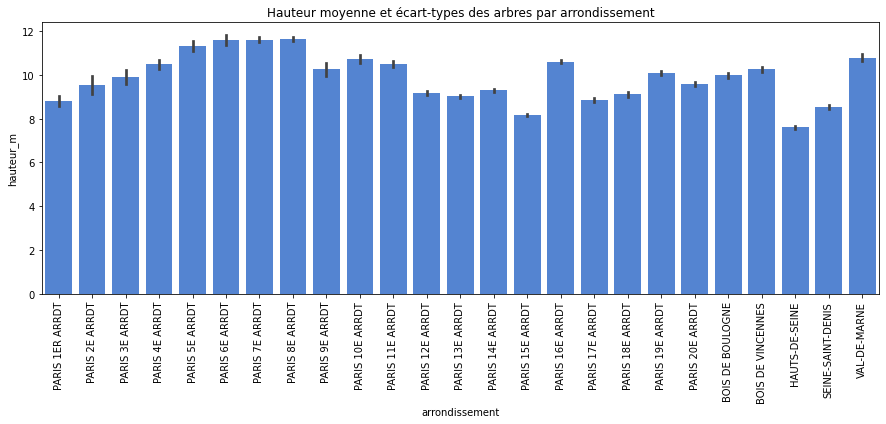

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
grp = sns.barplot(ax=ax, x="arrondissement", y="hauteur_m", data=arbres, color=(0.25, 0.5, 0.9), order=arrdts)
grp.set_title("Hauteur moyenne et écart-types des arbres par arrondissement")
for item in grp.get_xticklabels():
    item.set_rotation(90)

### Analyse par arrondissement

Le 2e: arrondissement peu exigeant

Statistiques descriptives de la hauteur

mean     9.540146
25%      6.000000
50%      9.000000
75%     13.000000
Name: hauteur_m, dtype: float64


Statistiques descriptives de la circonférence

mean     77.666058
25%      38.000000
50%      68.500000
75%     103.250000
Name: circonference_cm, dtype: float64


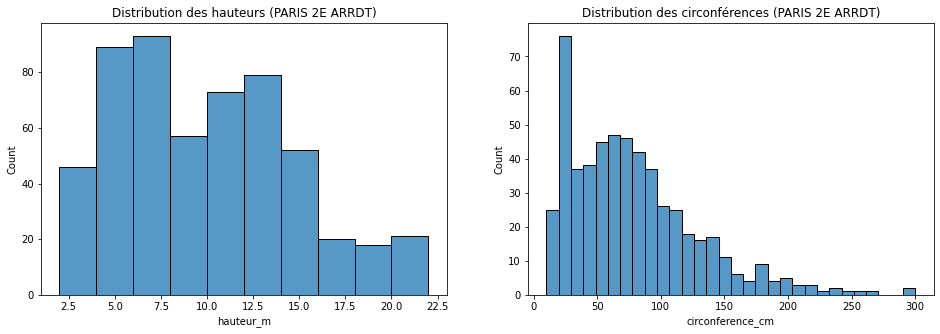

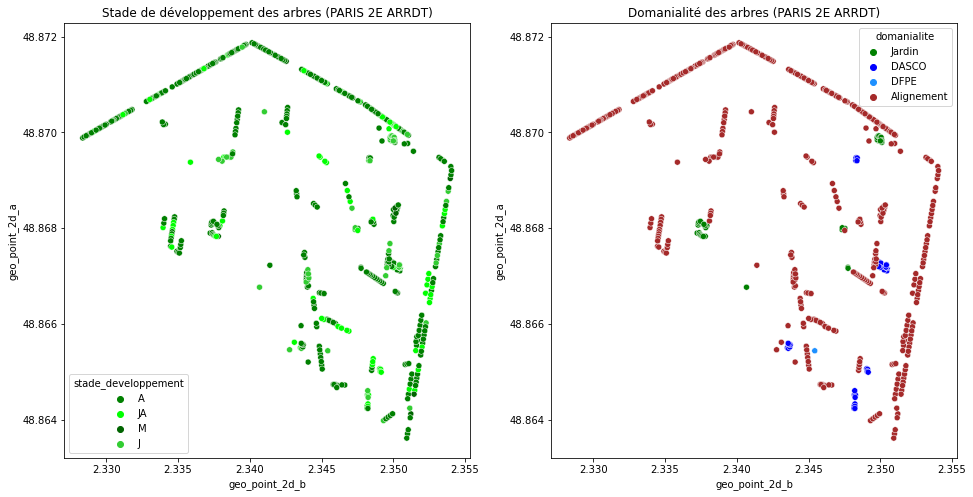

In [12]:
arrdt_insights(1, 1)

Le 4e: arrondissement non périphérique typique

Statistiques descriptives de la hauteur

mean    10.467518
25%      5.000000
50%     10.000000
75%     15.000000
Name: hauteur_m, dtype: float64


Statistiques descriptives de la circonférence

mean     90.629927
25%      45.000000
50%      75.000000
75%     120.000000
Name: circonference_cm, dtype: float64


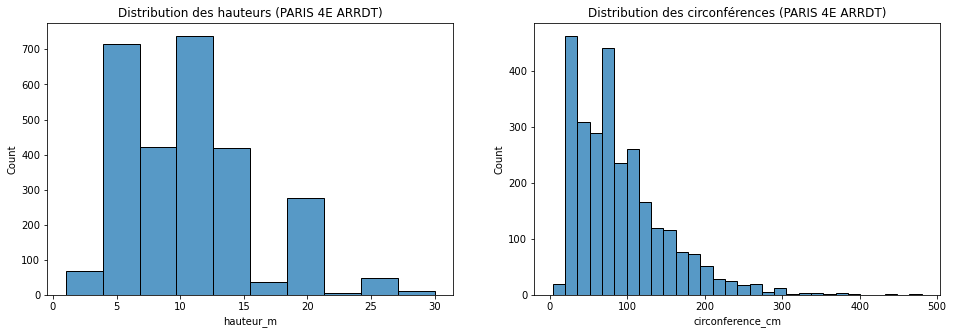

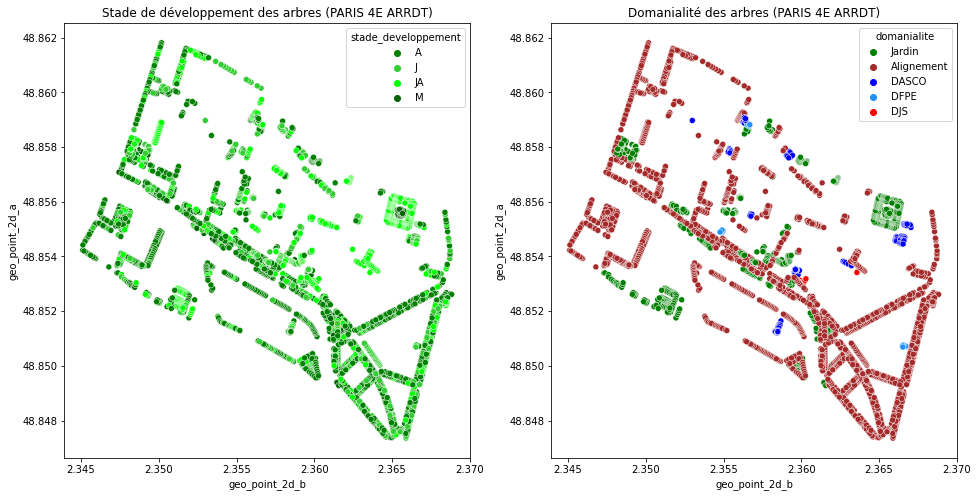

In [13]:
arrdt_insights(3, 1)

7e arrondissement: le cas du Champs de Mars

Statistiques descriptives de la hauteur

mean    11.604039
25%      8.000000
50%     11.000000
75%     15.000000
Name: hauteur_m, dtype: float64


Statistiques descriptives de la circonférence

mean     94.217013
25%      54.000000
50%      85.000000
75%     121.000000
Name: circonference_cm, dtype: float64


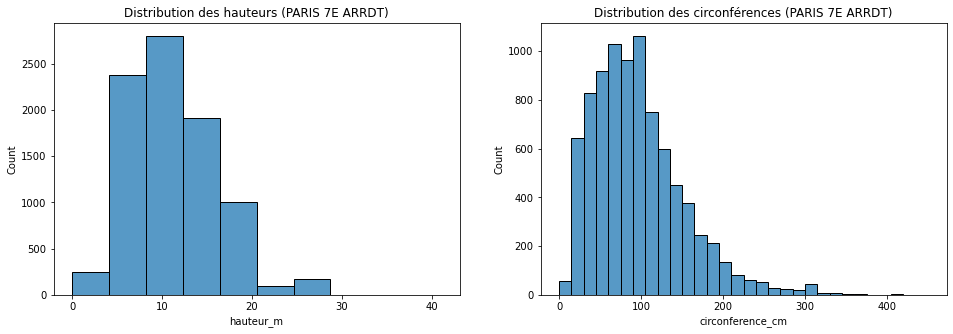

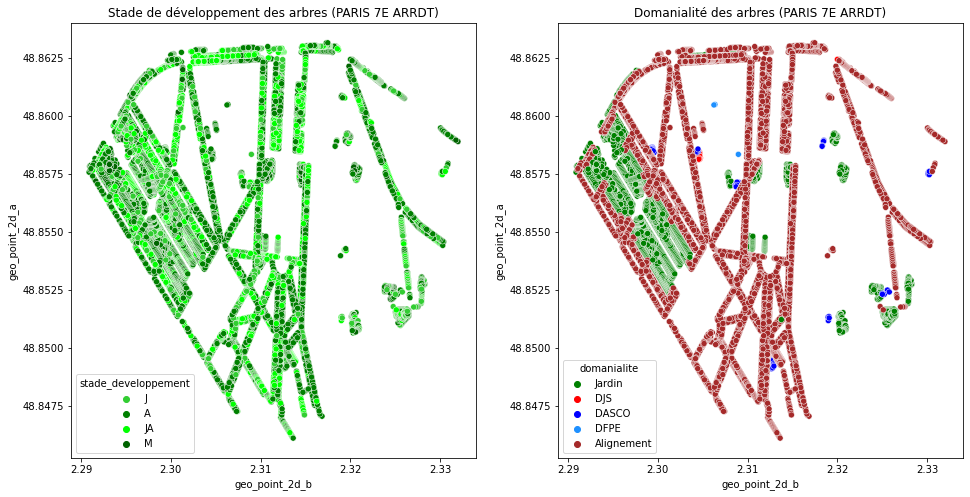

In [14]:
arrdt_insights(6, 1)

Le 15e: arrondissement périphérique typique

Statistiques descriptives de la hauteur

mean     8.166171
25%      5.000000
50%      8.000000
75%     10.000000
Name: hauteur_m, dtype: float64


Statistiques descriptives de la circonférence

mean     78.206169
25%      40.000000
50%      70.000000
75%     100.000000
Name: circonference_cm, dtype: float64


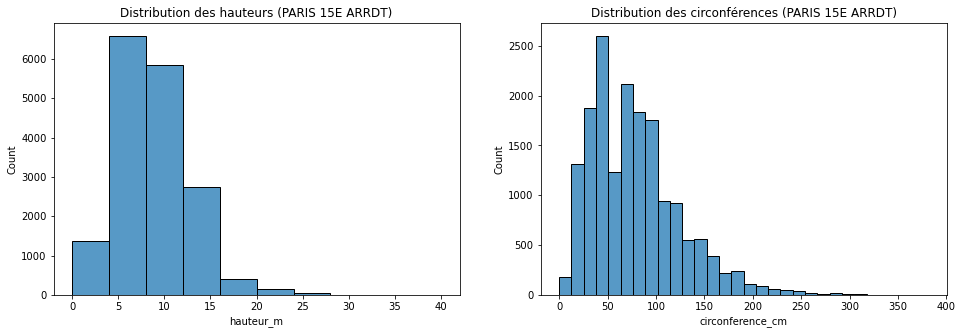

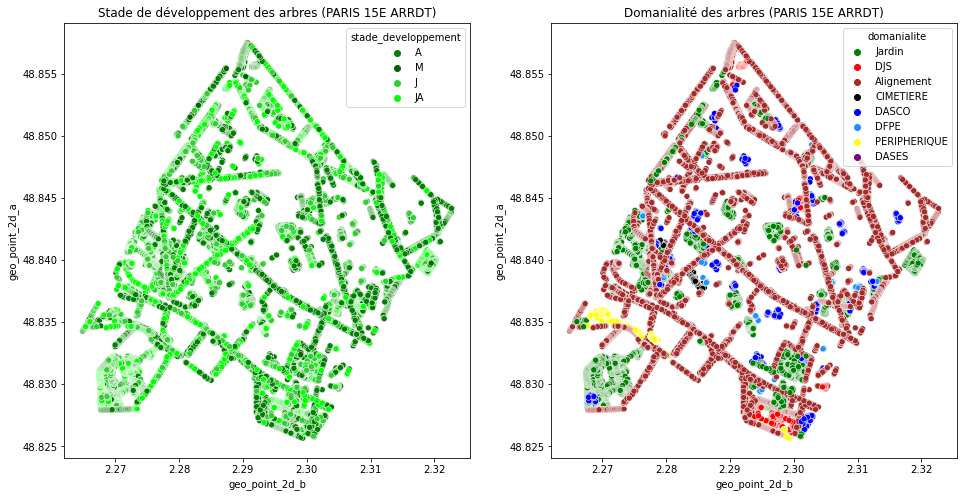

In [15]:
arrdt_insights(14, 1)

Le cas des bois: le Bois de Vincennes

Statistiques descriptives de la hauteur

mean    10.254127
25%      5.000000
50%      9.000000
75%     14.000000
Name: hauteur_m, dtype: float64


Statistiques descriptives de la circonférence

mean     87.285752
25%      40.000000
50%      80.000000
75%     115.000000
Name: circonference_cm, dtype: float64


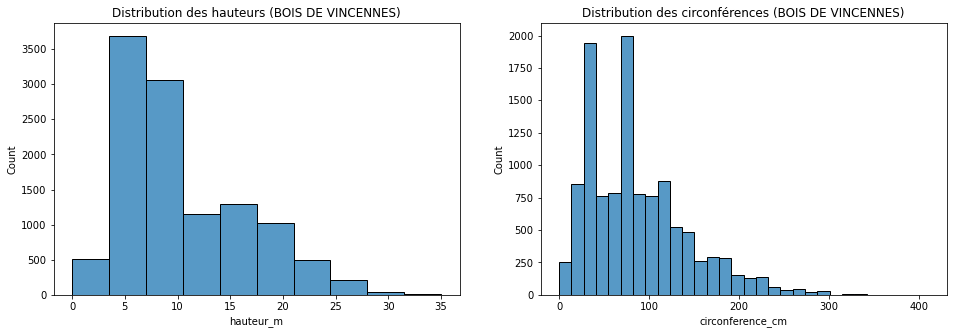

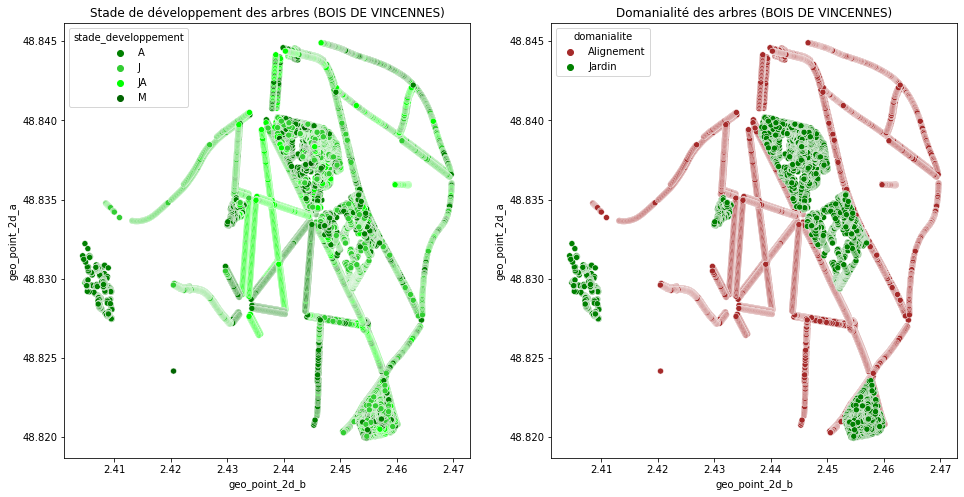

In [16]:
arrdt_insights(21, 1)

Le cas particulier des arbres dans les départements limitrophes

Statistiques descriptives de la hauteur

mean     8.524028
25%      5.000000
50%      7.000000
75%     10.000000
Name: hauteur_m, dtype: float64


Statistiques descriptives de la circonférence

mean     86.937338
25%      50.000000
50%      75.000000
75%     100.000000
Name: circonference_cm, dtype: float64


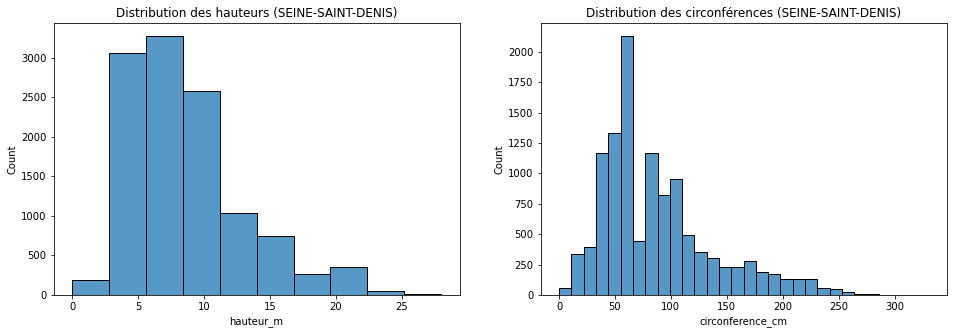

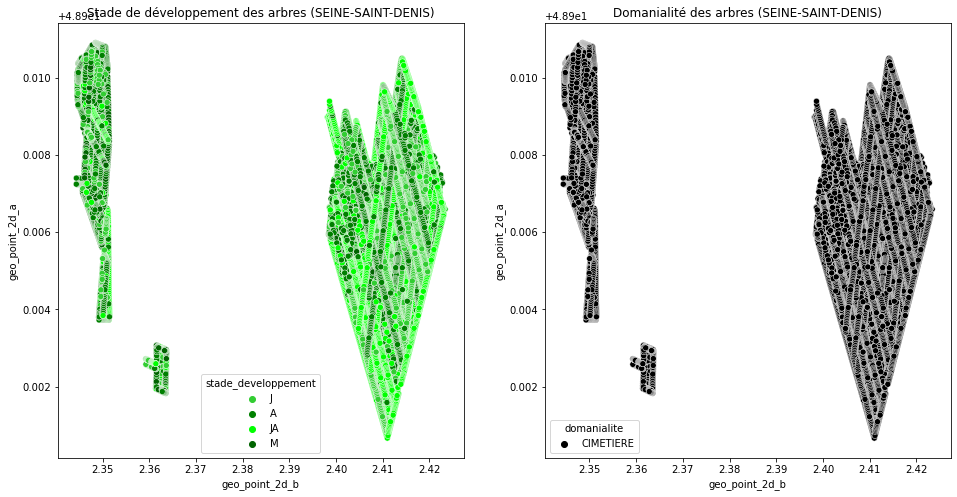

In [17]:
arrdt_insights(23, 1)